# Import all Libraries

In [412]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
%matplotlib inline
import mpl_toolkits

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_decision_regions
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# Import and check data

In [413]:
rawdata = pd.read_csv("regression_data_clean.csv")
rawdata.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [414]:
rawdata.shape

(21597, 21)

In [415]:
# Convert the date column into pandas datetime for sorting.

rawdata['date'] = pd.to_datetime(rawdata['date'])

## There were a number of duplicate ids, so to give a more accurate picture of the current property market, I  used only the most recent sale data from duplicated properties.

In [416]:
rawdata = rawdata.sort_values(by=['id', 'date'])

In [417]:
rawdata = rawdata.drop_duplicates(['id'], keep='last')

In [418]:
rawdata_duplicates = rawdata[rawdata.duplicated(['id'], keep=False)]

In [419]:
rawdata_duplicates

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price


In [420]:
rawdata.shape

(21420, 21)

### Now to sort the columns with lots of 0s

In [421]:
#A function to reduce columns with limited data into boolean

def ColumnReducer (x):
    if x == 0:
        n = 0
    elif x > 0:
        n = 1
    return n


In [422]:
rawdata['waterfront'] = rawdata['waterfront'].apply(ColumnReducer)
rawdata['view'] = rawdata['view'].apply(ColumnReducer)
rawdata['sqft_basement'] = rawdata['sqft_basement'].apply(ColumnReducer)
rawdata['renovated'] = rawdata['yr_renovated'].apply(ColumnReducer)

In [423]:
rawdata.reset_index()
rawdata.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,renovated
2495,1000102,2015-04-22,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,47.3262,-122.214,2060,7316,300000,0
6729,1200019,2014-05-08,4,1.75,2060,26036,1.0,0,0,4,8,1160,1,1947,0,98166,47.4444,-122.351,2590,21891,647500,0
8404,1200021,2014-08-11,3,1.00,1460,43000,1.0,0,0,3,7,1460,0,1952,0,98166,47.4434,-122.347,2250,20023,400000,0
8800,2800031,2015-04-01,3,1.00,1430,7599,1.5,0,0,4,6,1010,1,1930,0,98168,47.4783,-122.265,1290,10320,235000,0
3553,3600057,2015-03-19,4,2.00,1650,3504,1.0,0,0,3,7,760,1,1951,2013,98144,47.5803,-122.294,1480,3504,402500,1


### There are a number of columns that will not be help with the model so I will drop them before further exploration

In [424]:
rawdata = rawdata.drop(["id","date","lat","long","yr_renovated"], axis=1)

### The sqft_living and sqft_lot have more recent values in sqft_living15 and sqft_lot. So will drop the older values for a more up to date value of each property.

In [425]:
rawdata = rawdata.drop(["sqft_living","sqft_lot"], axis=1)

### Now for a quick look at the data

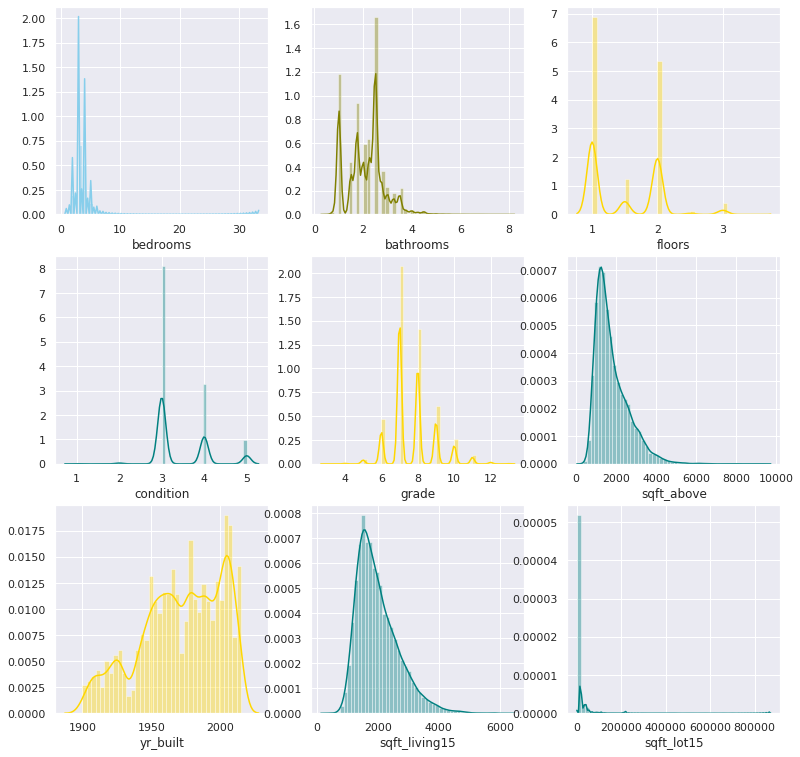

In [426]:
f, axes = plt.subplots(3, 3, figsize=(13, 13), sharex=False)
sns.distplot( rawdata["bedrooms"] , color="skyblue", ax=axes[0, 0])
sns.distplot( rawdata["bathrooms"] , color="olive", ax=axes[0, 1])
sns.distplot( rawdata["floors"] , color="gold", ax=axes[0, 2])
sns.distplot( rawdata["condition"] , color="teal", ax=axes[1, 0])
sns.distplot( rawdata["grade"] , color="gold", ax=axes[1, 1])
sns.distplot( rawdata["sqft_above"] , color="teal", ax=axes[1, 2])
sns.distplot( rawdata["yr_built"] , color="gold", ax=axes[2, 0])
sns.distplot( rawdata["sqft_living15"] , color="teal", ax=axes[2, 1])
sns.distplot( rawdata["sqft_lot15"] , color="teal", ax=axes[2, 2])

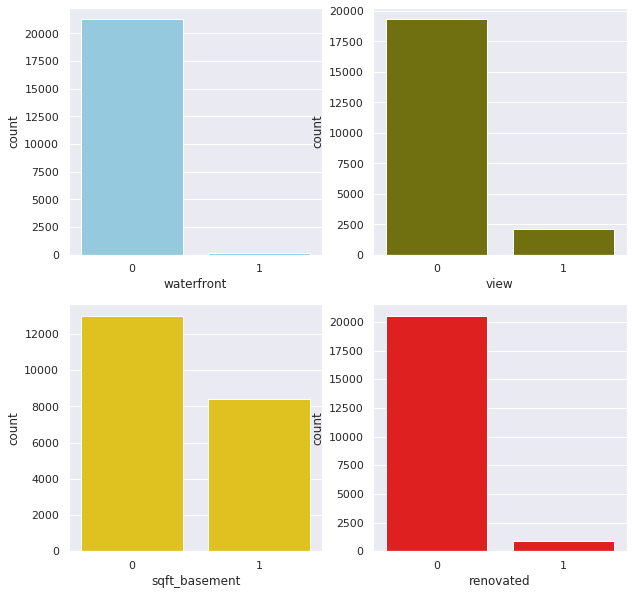

In [427]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
sns.countplot( rawdata["waterfront"] , color="skyblue", ax=axes[0, 0])
sns.countplot( rawdata["view"] , color="olive", ax=axes[0, 1])
sns.countplot( rawdata["sqft_basement"] , color="gold", ax=axes[1, 0])
sns.countplot( rawdata["renovated"] , color="red", ax=axes[1, 1])

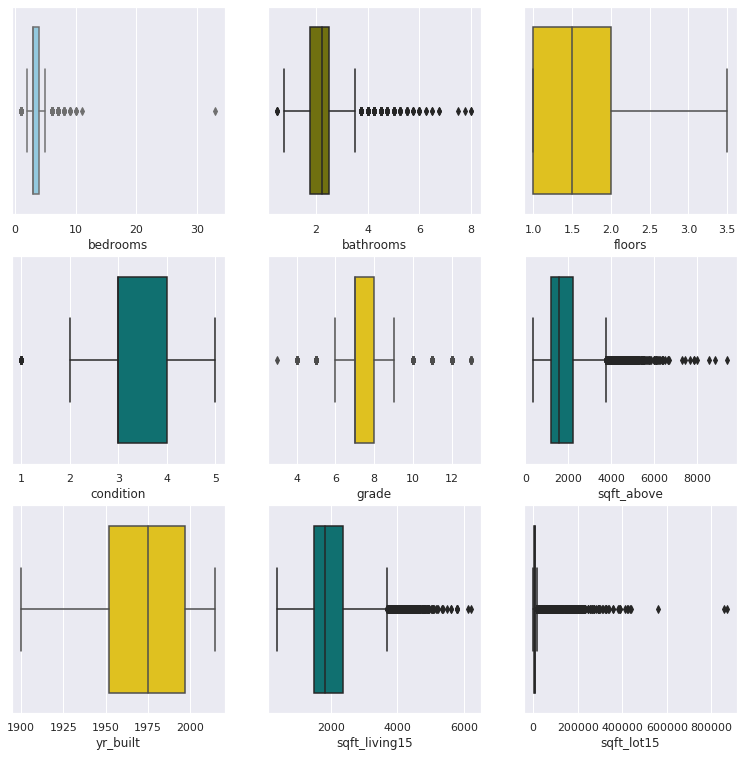

In [428]:
f, axes = plt.subplots(3, 3, figsize=(13, 13), sharex=False)
sns.boxplot( rawdata["bedrooms"] , color="skyblue", ax=axes[0, 0])
sns.boxplot( rawdata["bathrooms"] , color="olive", ax=axes[0, 1])
sns.boxplot( rawdata["floors"] , color="gold", ax=axes[0, 2])
sns.boxplot( rawdata["condition"] , color="teal", ax=axes[1, 0])
sns.boxplot( rawdata["grade"] , color="gold", ax=axes[1, 1])
sns.boxplot( rawdata["sqft_above"] , color="teal", ax=axes[1, 2])
sns.boxplot( rawdata["yr_built"] , color="gold", ax=axes[2, 0])
sns.boxplot( rawdata["sqft_living15"] , color="teal", ax=axes[2, 1])
sns.boxplot( rawdata["sqft_lot15"] , color="teal", ax=axes[2, 2])

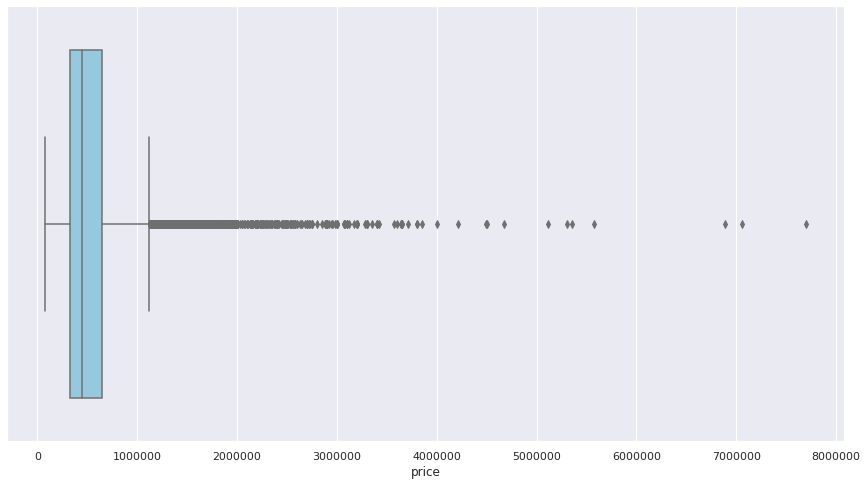

In [429]:
plt.figure(figsize=(15,8))
sns.boxplot( rawdata["price"] , color="skyblue")


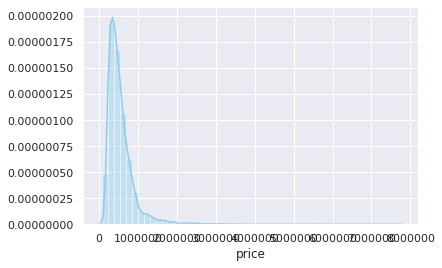

In [430]:
sns.distplot( rawdata["price"] , color="skyblue")


In [431]:
# all_outlier_gone = rawdata[rawdata.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

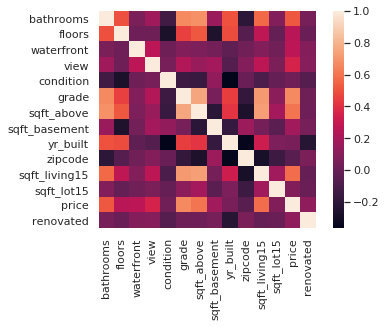

In [432]:
corr = rawdata.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()
#fig = plt.figure()
sns.set(font_scale=1)  
sns.heatmap(corr, vmax=1, square=True)

In [433]:
corr_list = corr['price'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list

grade            0.666835
sqft_above       0.604424
sqft_living15    0.583792
bathrooms        0.525215
view             0.358451
waterfront       0.266995
floors           0.254972
sqft_basement    0.180120
renovated        0.126371
sqft_lot15       0.082045
yr_built         0.051012
condition        0.034219
zipcode         -0.051169
Name: price, dtype: float64

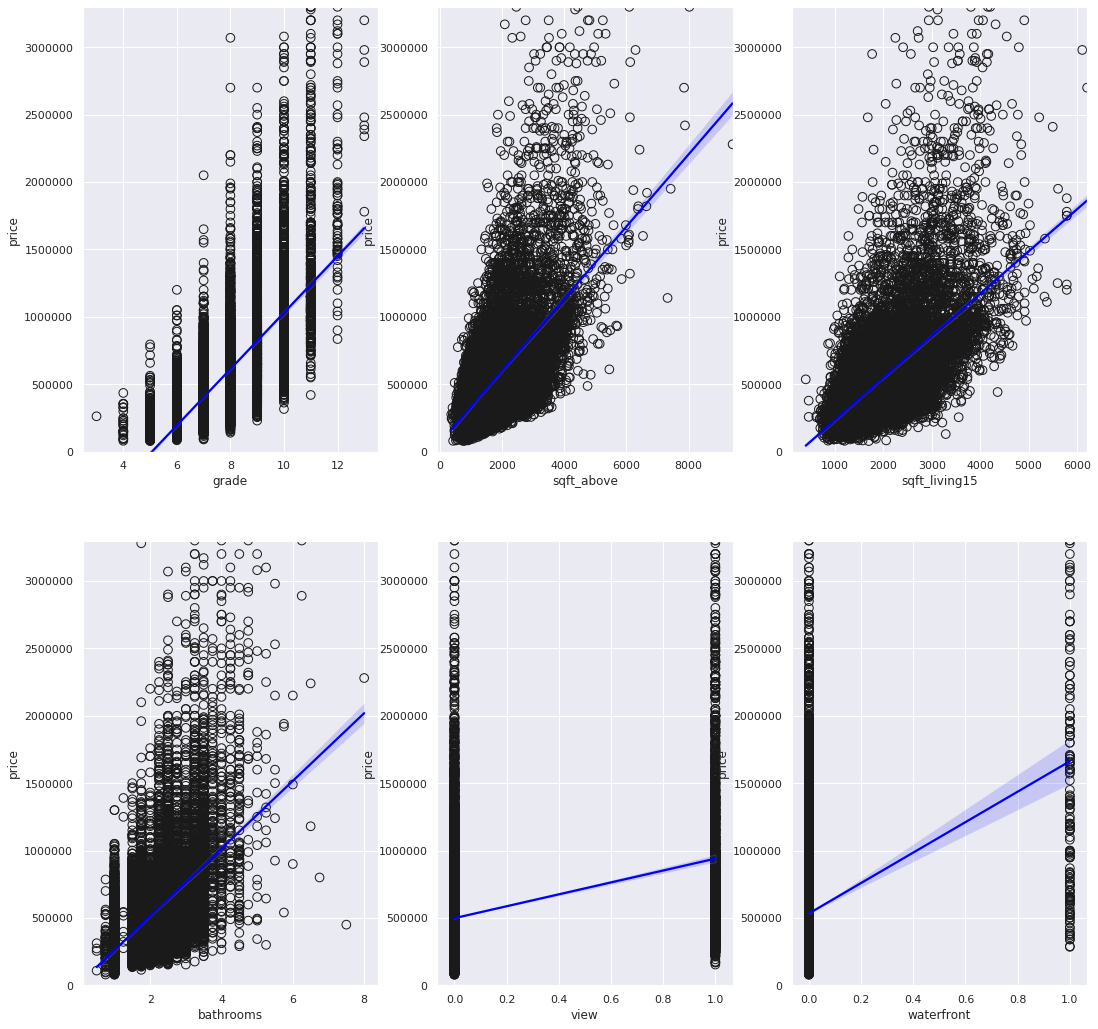

In [434]:
plt.figure(figsize=(18,18))
for i in range(6):
    ii = '23'+str(i+1)
    plt.subplot(ii)
    feature = corr_list.index.values[i]
    plt.scatter(rawdata[feature], rawdata['price'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = feature, y = 'price', data = rawdata,scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([0,3300000])

In [435]:
data = rawdata.copy()

### Now for further cleaning and to deal with the outliers

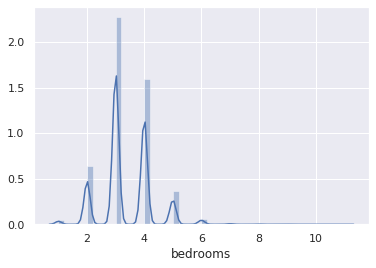

In [436]:
# The bedroom column has one massive outlier, which I will remove manually
data = data[data['bedrooms']<=11]
sns.distplot(data['bedrooms']) # Now has a slightly better distribution.

In [347]:
# The waterfront, view, and renovated columns have a big percentatge of 0 values, so will drop these entirely.
data = data.drop(["waterfront","view","renovated"], axis=1)

In [437]:

#### Dropping property under 3000000


data = data[data['price']<=3000000]

In [113]:
data.shape

(21220, 12)

### Dealing with the skewed data

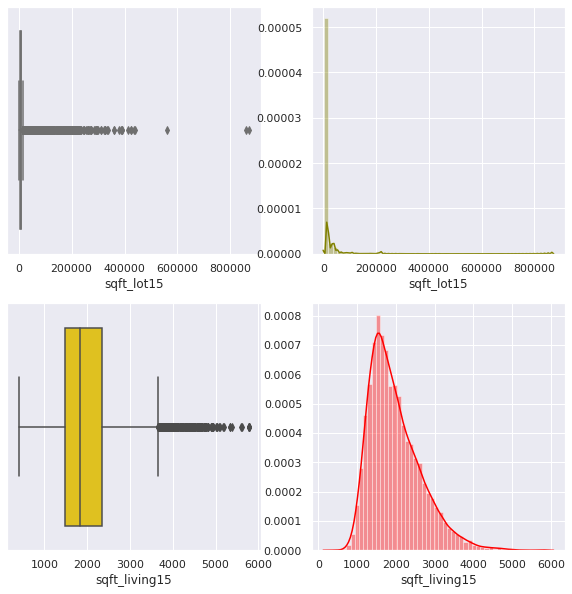

In [114]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
sns.boxplot( data["sqft_lot15"] , color="skyblue", ax=axes[0, 0])
sns.distplot( data["sqft_lot15"] , color="olive", ax=axes[0, 1])
sns.boxplot( data["sqft_living15"] , color="gold", ax=axes[1, 0])
sns.distplot( data["sqft_living15"] , color="red", ax=axes[1, 1])

In [115]:
data["sqft_lot15_log"] = np.log(data["sqft_lot15"])
data["sqft_living15_log"] = np.log(data["sqft_living15"])

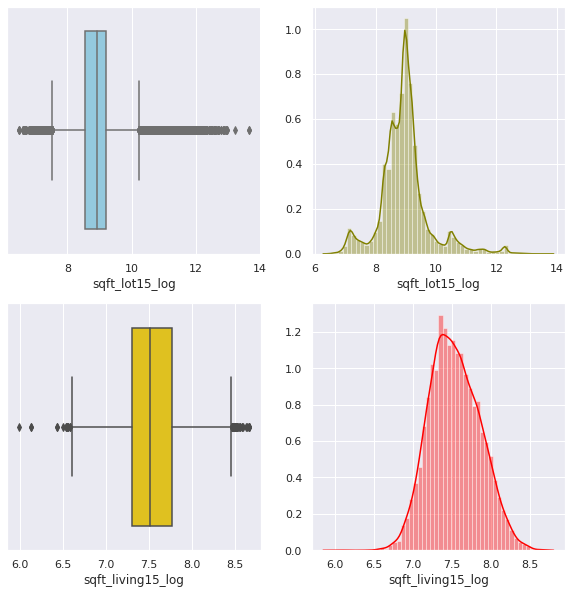

In [116]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
sns.boxplot( data["sqft_lot15_log"] , color="skyblue", ax=axes[0, 0])
sns.distplot( data["sqft_lot15_log"] , color="olive", ax=axes[0, 1])
sns.boxplot( data["sqft_living15_log"] , color="gold", ax=axes[1, 0])
sns.distplot( data["sqft_living15_log"] , color="red", ax=axes[1, 1])

In [117]:
# The sqft_living15_log gives us a more normal distribution. So will drop the original column.
#The sqft_lot15_log has a worse distribution, so will drop this too and try another method.

data = data.drop(["sqft_living15","sqft_lot15_log"], axis=1)

In [118]:
data= data[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'sqft_above',
    'sqft_lot15','sqft_living15_log', 'sqft_basement','zipcode', 'yr_built','price']]

In [119]:
data.columns = ['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'sqft_above',
       'sqft_lot15', 'sqft_living15_log', 'basement', 'zipcode',
       'yr_built', 'price']

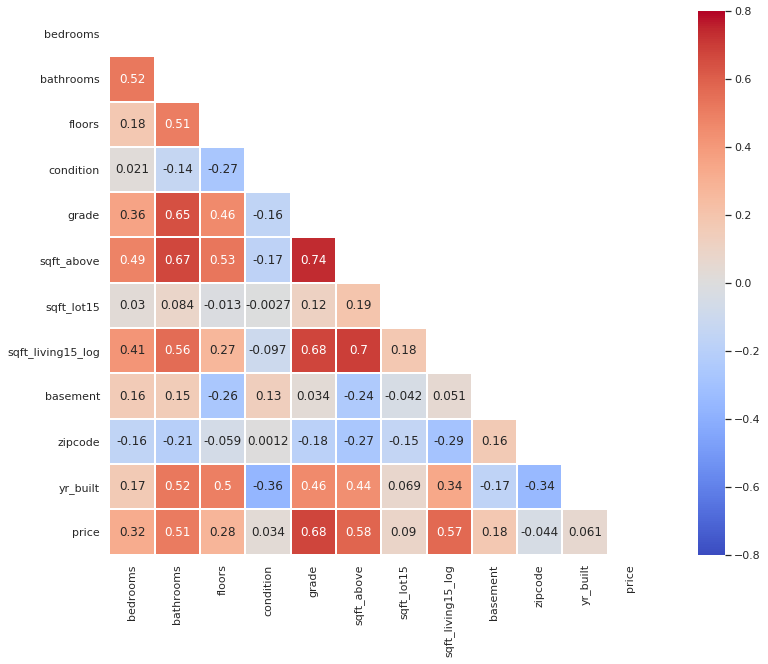

In [120]:
#A quick look at correlation may allow me to drop columns

mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8, annot=True )

In [121]:
# Looking at the heat map I can see that there are various columns with very little correlation to the price;
# These include zipcode, condition,sqdft_lot15, yr_built, basement. So will drop these now.

data = data.drop(["zipcode","condition","yr_built", "sqft_lot15", "basement"], axis=1)

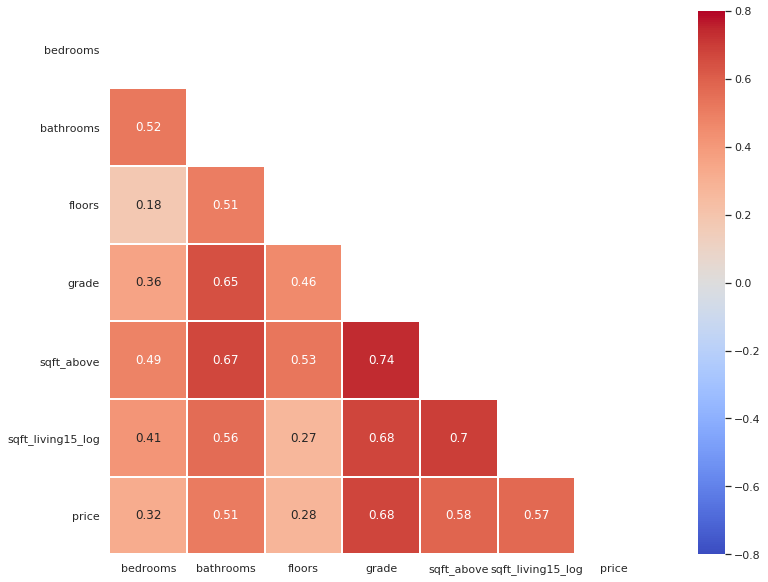

In [122]:
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8, annot=True )

In [123]:
# There is lots of multicollinearity with the sqft_above and other columns, so will drop that column.
data = data.drop(["sqft_above"], axis=1)

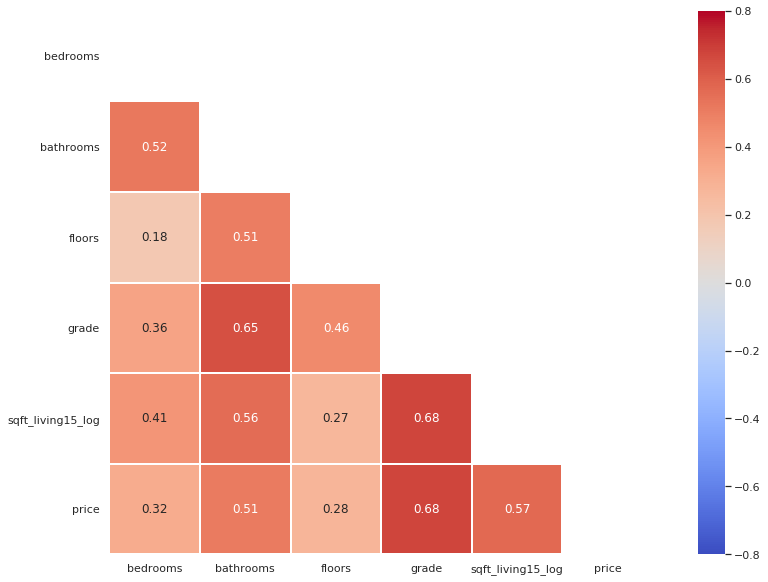

In [124]:
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8,annot=True )

In [125]:
data_for_model = data.copy()

In [126]:
data_for_model = data_for_model.reset_index()
data_for_model = data_for_model.drop(["index"], axis=1)
data_for_model

,bedrooms,bathrooms,floors,grade,sqft_living15_log,price
0,6,3.00,2.0,7,7.630461,300000
1,4,1.75,1.0,8,7.859413,647500
2,3,1.00,1.0,7,7.718685,400000
3,3,1.00,1.5,6,7.162397,235000
4,4,2.00,1.0,7,7.299797,402500
...,...,...,...,...,...,...
21215,5,2.00,1.5,7,7.081709,365000
21216,2,1.00,1.0,7,7.565275,380000
21217,3,1.00,1.0,7,7.319865,339000
21218,2,1.75,1.5,9,7.272398,399900


### Now I will do a quick test of the data in some regression models.

In [127]:
transformer = StandardScaler().fit(data_for_model.iloc[:,:-1])
x_standardized = transformer.transform(data_for_model.iloc[:,:-1])

In [128]:
full_standardized = pd.DataFrame(x_standardized,columns=data_for_model.columns.tolist()[:-1])
full_standardized.head()
X = full_standardized
y = data_for_model['price']

In [129]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [130]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4)

In [131]:
knn_predictions = knn_model.predict(X_test)

In [132]:
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 140526.70
The mean squared error of the model in the test set is: 37352691904.56
The root mean squared error of the model in the test set is: 193268.45
The R2 of the model in the test set is: 0.51


In [133]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)

In [134]:
lm_predictions = lm_model.predict(X_test)

In [135]:
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 146547.07
The mean squared error of the model in the test set is: 38661772084.36
The root mean squared error of the model in the test set is: 196625.97
The R2 of the model in the test set is: 0.50


In [136]:
scores = []
for i in range(2,10): 
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

Text(0, 0.5, 'R2')

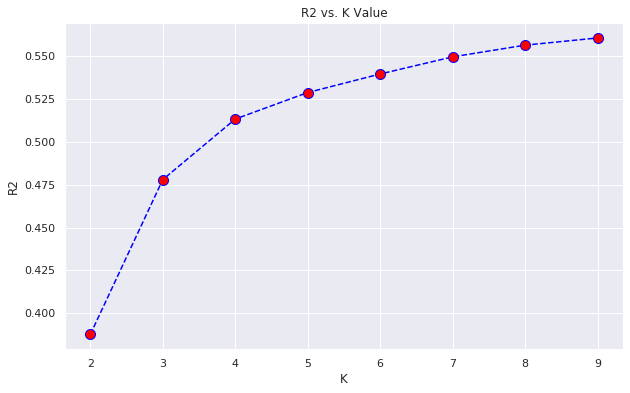

In [137]:
plt.figure(figsize=(10,6))
plt.plot(range(2,10),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('R2 vs. K Value')
plt.xlabel('K')
plt.ylabel('R2')

In [138]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 134063.66
The mean squared error of the model in the test set is: 33723484360.39
The root mean squared error of the model in the test set is: 183639.55
The R2 of the model in the test set is: 0.56


In [139]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 143093.30
The mean squared error of the model in the test set is: 40037935332.24
The root mean squared error of the model in the test set is: 200094.82
The R2 of the model in the test set is: 0.48


## Using a range of regression models, the best score was 0.55

### Now to try scaling the data and use some dummy variables.

In [140]:
data_for_scaling = data_for_model.copy()
data_for_scaling

,bedrooms,bathrooms,floors,grade,sqft_living15_log,price
0,6,3.00,2.0,7,7.630461,300000
1,4,1.75,1.0,8,7.859413,647500
2,3,1.00,1.0,7,7.718685,400000
3,3,1.00,1.5,6,7.162397,235000
4,4,2.00,1.0,7,7.299797,402500
...,...,...,...,...,...,...
21215,5,2.00,1.5,7,7.081709,365000
21216,2,1.00,1.0,7,7.565275,380000
21217,3,1.00,1.0,7,7.319865,339000
21218,2,1.75,1.5,9,7.272398,399900


In [141]:
logs_for_scaler = data_for_scaling[['sqft_living15_log']]

In [142]:
transformer = StandardScaler().fit(logs_for_scaler)
logs_standardized = transformer.transform(logs_for_scaler)
standardized = pd.DataFrame(logs_standardized)
standardized.columns = ['scaled_living15']


In [143]:
data_for_scaling = data_for_scaling.drop(["sqft_living15_log"], axis=1)

In [144]:
data_for_scaling

,bedrooms,bathrooms,floors,grade,price
0,6,3.00,2.0,7,300000
1,4,1.75,1.0,8,647500
2,3,1.00,1.0,7,400000
3,3,1.00,1.5,6,235000
4,4,2.00,1.0,7,402500
...,...,...,...,...,...
21215,5,2.00,1.5,7,365000
21216,2,1.00,1.0,7,380000
21217,3,1.00,1.0,7,339000
21218,2,1.75,1.5,9,399900


In [145]:
data_for_scaling = pd.concat([data_for_scaling,standardized],axis=1)
data_for_scaling = data_for_scaling[['bedrooms','bathrooms','floors','grade','scaled_living15','price']]
scaled_data = data_for_scaling.copy()
scaled_data

,bedrooms,bathrooms,floors,grade,scaled_living15,price
0,6,3.00,2.0,7,0.295870,300000
1,4,1.75,1.0,8,1.004435,647500
2,3,1.00,1.0,7,0.568908,400000
3,3,1.00,1.5,6,-1.152703,235000
4,4,2.00,1.0,7,-0.727476,402500
...,...,...,...,...,...,...
21215,5,2.00,1.5,7,-1.402421,365000
21216,2,1.00,1.0,7,0.094131,380000
21217,3,1.00,1.0,7,-0.665370,339000
21218,2,1.75,1.5,9,-0.812270,399900


In [146]:
# Now to try putting the scaled data through a model to see if it improves it at all

In [147]:
transformer = StandardScaler().fit(scaled_data.iloc[:,:-1])
x_standardized = transformer.transform(scaled_data.iloc[:,:-1])

In [148]:
full_standardized = pd.DataFrame(x_standardized,columns=scaled_data.columns.tolist()[:-1])
full_standardized.head()
X = full_standardized
y = scaled_data['price']

In [149]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [150]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4)

In [151]:
knn_predictions = knn_model.predict(X_test)
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 140526.70
The mean squared error of the model in the test set is: 37352691904.56
The root mean squared error of the model in the test set is: 193268.45
The R2 of the model in the test set is: 0.51


In [152]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)

In [153]:
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 146547.07
The mean squared error of the model in the test set is: 38661772084.36
The root mean squared error of the model in the test set is: 196625.97
The R2 of the model in the test set is: 0.50


In [154]:
scores = []
for i in range(2,10):
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

Text(0, 0.5, 'R2')

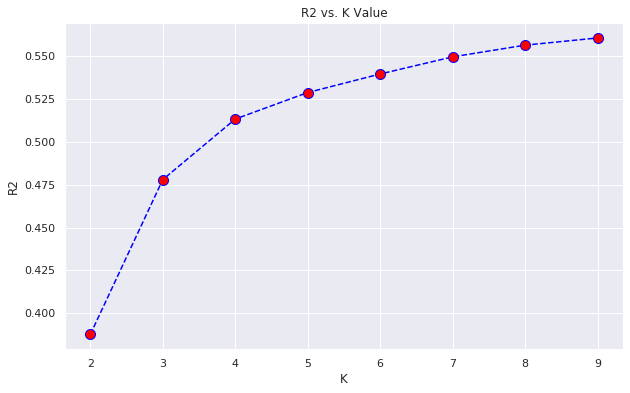

In [155]:
plt.figure(figsize=(10,6))
plt.plot(range(2,10),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('R2 vs. K Value')
plt.xlabel('K')
plt.ylabel('R2')

In [156]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 134063.66
The mean squared error of the model in the test set is: 33723484360.39
The root mean squared error of the model in the test set is: 183639.55
The R2 of the model in the test set is: 0.56


In [157]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 143093.30
The mean squared error of the model in the test set is: 40037935332.24
The root mean squared error of the model in the test set is: 200094.82
The R2 of the model in the test set is: 0.48


## This time around I got a highest score of 0.56 with the uniform model.

In [158]:
scaled_data.columns

Index(['bedrooms', 'bathrooms', 'floors', 'grade', 'scaled_living15', 'price'], dtype='object')

In [159]:
y = scaled_data['price']

#I ran the code several times, dropping different collumns to see the effect on the outcome

X = scaled_data.drop(["price",'floors'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [160]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 147242.38
The mean squared error of the model in the test set is: 40145584801.62
The root mean squared error of the model in the test set is: 200363.63
The R2 of the model in the test set is: 0.48


In [161]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)
lm_predictions = lm_model.predict(X_test)
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 146785.18
The mean squared error of the model in the test set is: 38822264510.94
The root mean squared error of the model in the test set is: 197033.66
The R2 of the model in the test set is: 0.49


In [162]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 138774.66
The mean squared error of the model in the test set is: 35678071514.24
The root mean squared error of the model in the test set is: 188886.40
The R2 of the model in the test set is: 0.54


In [163]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 150023.65
The mean squared error of the model in the test set is: 43107503374.75
The root mean squared error of the model in the test set is: 207623.47
The R2 of the model in the test set is: 0.44


In [164]:
# Now to try using some dummies

In [165]:
bathrooms = scaled_data['bathrooms']
floor = scaled_data['floors']
bedrooms = scaled_data['bedrooms']
grade = scaled_data['grade']


In [166]:
bedrooms_encoded = pd.get_dummies(bedrooms, drop_first=True)

In [167]:
bedrooms_encoded.columns = ['bed2','bed3','bed4','bed5','bed6','bed7','bed8','bed9','bed10']
bedrooms_encoded

,bed2,bed3,bed4,bed5,bed6,bed7,bed8,bed9,bed10
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
21215,0,0,0,1,0,0,0,0,0
21216,1,0,0,0,0,0,0,0,0
21217,0,1,0,0,0,0,0,0,0
21218,1,0,0,0,0,0,0,0,0


In [168]:
floors_encoded = pd.get_dummies(floor, drop_first=True)
floors_encoded.columns = ['fl1.5','fl2.0','fl2.5','fl3.0','fl3.5']
floors_encoded

,fl1.5,fl2.0,fl2.5,fl3.0,fl3.5
0,0,1,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
21215,1,0,0,0,0
21216,0,0,0,0,0
21217,0,0,0,0,0
21218,1,0,0,0,0


In [169]:
bathrooms_encoded = pd.get_dummies(bathrooms, drop_first=True)
#floors_encoded.columns = ['fl1.5','fl2.0','fl2.5','fl3.0','fl3.5']
bathrooms_encoded

,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.50,6.75,7.50
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21215,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21216,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21217,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21218,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [170]:
grade_encoded = pd.get_dummies(grade, drop_first=True)
grade_encoded.columns = ['gr4','gr5','gr6','gr7','gr8','gr9','gr10','gr11','gr12','gr13']
grade_encoded


,gr4,gr5,gr6,gr7,gr8,gr9,gr10,gr11,gr12,gr13
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
21215,0,0,0,1,0,0,0,0,0,0
21216,0,0,0,1,0,0,0,0,0,0
21217,0,0,0,1,0,0,0,0,0,0
21218,0,0,0,0,0,1,0,0,0,0


In [171]:
encoded_data = pd.concat([bedrooms_encoded,bathrooms_encoded,grade_encoded,floors_encoded],axis=1)
encoded_data

,bed2,bed3,bed4,bed5,bed6,bed7,bed8,bed9,bed10,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.5,6.75,7.5,gr4,gr5,gr6,gr7,gr8,gr9,gr10,gr11,gr12,gr13,fl1.5,fl2.0,fl2.5,fl3.0,fl3.5
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21215,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
21216,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21217,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21218,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [172]:
for_encoded = scaled_data.drop(["bedrooms","bathrooms","floors","grade"], axis=1)

In [173]:
encoded_scaled_data = pd.concat([encoded_data,for_encoded],axis=1)
encoded_scaled_data

,bed2,bed3,bed4,bed5,bed6,bed7,bed8,bed9,bed10,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.5,6.75,7.5,gr4,gr5,gr6,gr7,gr8,gr9,gr10,gr11,gr12,gr13,fl1.5,fl2.0,fl2.5,fl3.0,fl3.5,scaled_living15,price
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.295870,300000
1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.004435,647500
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.568908,400000
3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,-1.152703,235000
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.727476,402500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21215,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,-1.402421,365000
21216,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.094131,380000
21217,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.665370,339000
21218,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,-0.812270,399900


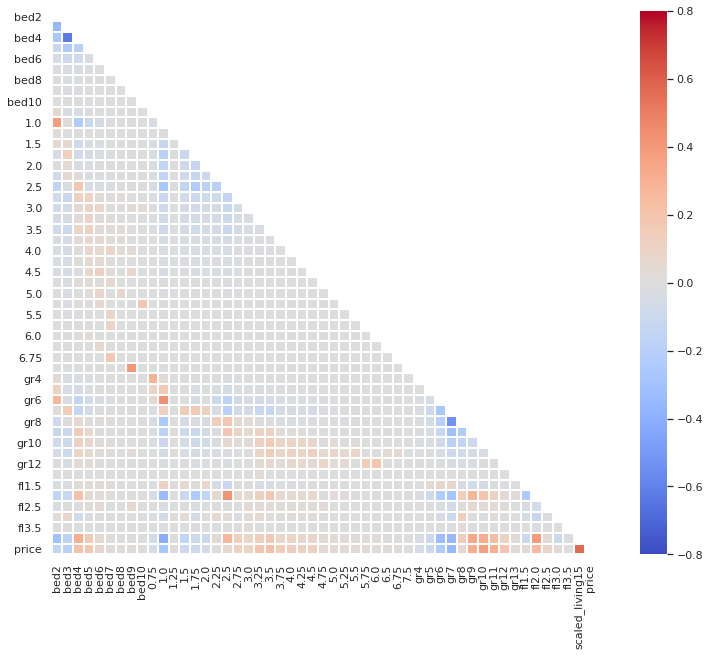

In [174]:
mask = np.zeros_like(encoded_scaled_data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(encoded_scaled_data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8)

In [176]:
new_try = encoded_scaled_data.drop(['bed2','bed3','bed6', 'bed7','bed8','bed8','bed9','bed10',0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,
3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.5,6.75,7.5,
'gr4','gr5','gr6','gr7','gr8','fl1.5','fl2.5','fl3.0','fl3.5'], axis=1)


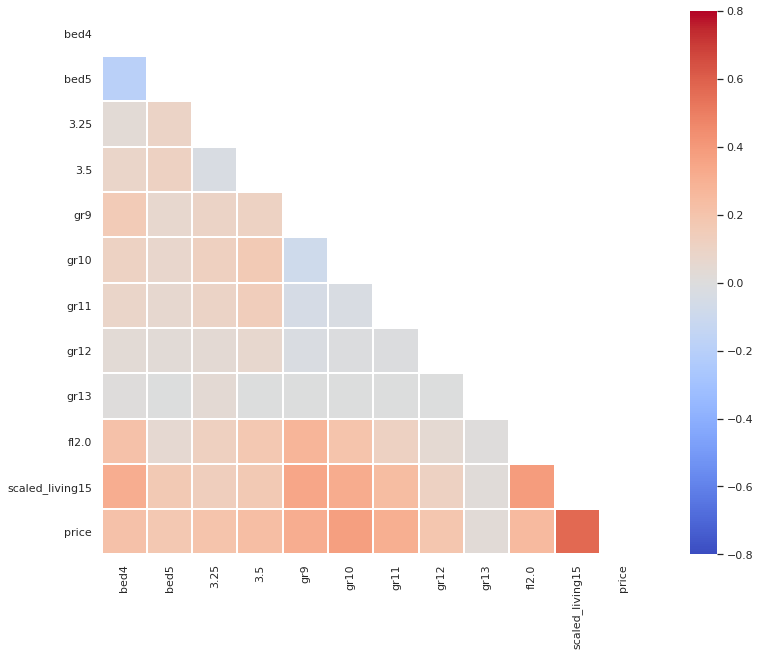

In [177]:
mask = np.zeros_like(new_try.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(new_try.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8)

In [179]:
new_try = new_try.drop(['gr13'])

KeyError: "['gr13'] not found in axis"

In [180]:
#Now to test this in some models

In [181]:
y = new_try['price']
X = new_try.drop(["price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [182]:
y_test

3932     629000
15411    702000
14577    900000
16456    328000
7955     450000
          ...  
18374    605000
2482     320000
19085    299900
9750     430000
17396    350000
Name: price, Length: 6366, dtype: int64

In [183]:
X_test

,bed4,bed5,3.25,3.5,gr9,gr10,gr11,gr12,gr13,fl2.0,scaled_living15
3932,1,0,0,0,1,0,0,0,0,1,1.520518
15411,1,0,0,0,0,0,0,0,0,1,1.040076
14577,1,0,1,0,0,1,0,0,0,1,2.057682
16456,0,0,0,0,0,0,0,0,0,0,-0.447753
7955,0,0,0,0,0,0,0,0,0,0,-0.790853
...,...,...,...,...,...,...,...,...,...,...,...
18374,1,0,0,0,0,0,0,0,0,1,0.992462
2482,0,1,0,0,0,0,0,0,0,0,-0.466916
19085,1,0,0,0,0,0,0,0,0,0,0.703486
9750,0,0,0,0,0,0,0,0,0,1,-0.943985


In [184]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 159821.17
The mean squared error of the model in the test set is: 46105987327.06
The root mean squared error of the model in the test set is: 214723.05
The R2 of the model in the test set is: 0.40


In [185]:
knn_predictions

array([751088.75, 557750.  , 743250.  , ..., 669500.  , 368247.5 ,
       300000.  ])

In [186]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)
lm_predictions = lm_model.predict(X_test)
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 147388.85
The mean squared error of the model in the test set is: 38444369690.61
The root mean squared error of the model in the test set is: 196072.36
The R2 of the model in the test set is: 0.50


In [215]:
lm.score(X_test,y_test)

0.49902330329564515

In [213]:
lm_predictions

array([ 793833.12235867,  535835.6509646 , 1161601.05550643, ...,
        545489.53001645,  341558.21333893,  455121.77227574])

In [204]:
y_test

3932     629000
15411    702000
14577    900000
16456    328000
7955     450000
          ...  
18374    605000
2482     320000
19085    299900
9750     430000
17396    350000
Name: price, Length: 6366, dtype: int64

In [209]:
y_actual = pd.DataFrame(y_test)
y_actual = y_actual.reset_index()
#y_actual = y_actual.drop(['index'])
y_actual[price]

,index,price
0,3932,629000
1,15411,702000
2,14577,900000
3,16456,328000
4,7955,450000
...,...,...
6361,18374,605000
6362,2482,320000
6363,19085,299900
6364,9750,430000


In [210]:
compare = pd.concat([y_actual['price'],lm_predict],axis=1)

In [211]:
compare

,price,0
0,629000,7.938331e+05
1,702000,5.358357e+05
2,900000,1.161601e+06
3,328000,4.207940e+05
4,450000,3.921281e+05
...,...,...
6361,605000,5.318576e+05
6362,320000,4.978874e+05
6363,299900,5.454895e+05
6364,430000,3.415582e+05


In [189]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 149945.07
The mean squared error of the model in the test set is: 40470367750.11
The root mean squared error of the model in the test set is: 201172.48
The R2 of the model in the test set is: 0.47


In [190]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 156281.65
The mean squared error of the model in the test set is: 45530327304.47
The root mean squared error of the model in the test set is: 213378.37
The R2 of the model in the test set is: 0.41


### Using the dummy columns the highest score was 0.57 with the lm_model

### I got rid of property over 6 mill and linReg score = 0.6614758959958058 :GradientBoostingRegressor-0.8711148712566448

In [439]:
data = data.reset_index()
#data = data.drop(['level_0','index'])
data

,index,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,price,renovated
0,2495,6,3.00,2.0,0,0,3,7,2400,0,1991,98002,2060,7316,300000,0
1,6729,4,1.75,1.0,0,0,4,8,1160,1,1947,98166,2590,21891,647500,0
2,8404,3,1.00,1.0,0,0,3,7,1460,0,1952,98166,2250,20023,400000,0
3,8800,3,1.00,1.5,0,0,4,6,1010,1,1930,98168,1290,10320,235000,0
4,3553,4,2.00,1.0,0,0,3,7,760,1,1951,98144,1480,3504,402500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,16723,5,2.00,1.5,0,0,3,7,1600,0,1927,98126,1190,4168,365000,0
21370,3257,2,1.00,1.0,0,0,5,7,840,1,1939,98126,1930,5150,380000,0
21371,7614,3,1.00,1.0,0,0,4,7,720,1,1942,98126,1510,4538,339000,0
21372,20963,2,1.75,1.5,0,0,3,9,900,1,2011,98027,1440,1188,399900,0


In [468]:
transformer = StandardScaler().fit(data.iloc[:,:-1])
x_standardized = transformer.transform(data.iloc[:,:-1])

In [469]:
full_standardized = pd.DataFrame(x_standardized,columns=data.columns.tolist()[:-1])
full_standardized.head()

,index,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,price
0,-1.331753,2.920451,1.167606,0.935249,-0.08207,-0.328338,-0.631812,-0.564884,0.755054,-0.803459,0.678347,-1.420203,0.110439,-0.198967,-0.711445
1,-0.653086,0.699591,-0.478617,-0.917480,-0.08207,-0.328338,0.906794,0.297779,-0.767049,1.244619,-0.819416,1.647127,0.888669,0.333585,0.341650
2,-0.384600,-0.410839,-1.466350,-0.917480,-0.08207,-0.328338,-0.631812,-0.564884,-0.398798,-0.803459,-0.649215,1.647127,0.389427,0.265331,-0.408396
3,-0.321125,-0.410839,-1.466350,0.008885,-0.08207,-0.328338,0.906794,-1.427548,-0.951174,1.244619,-1.398097,1.684534,-1.020198,-0.089204,-0.908427
4,-1.162166,0.699591,-0.149372,-0.917480,-0.08207,-0.328338,-0.631812,-0.564884,-1.258050,1.244619,-0.683255,1.235656,-0.741210,-0.338252,-0.400820


In [510]:
reg = LinearRegression()
labels = data['price']
train1 = full_standardized.drop([ 'price','index','bedrooms'],axis=1)

In [511]:
train1

,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,1.167606,0.935249,-0.08207,-0.328338,-0.631812,-0.564884,0.755054,-0.803459,0.678347,-1.420203,0.110439,-0.198967
1,-0.478617,-0.917480,-0.08207,-0.328338,0.906794,0.297779,-0.767049,1.244619,-0.819416,1.647127,0.888669,0.333585
2,-1.466350,-0.917480,-0.08207,-0.328338,-0.631812,-0.564884,-0.398798,-0.803459,-0.649215,1.647127,0.389427,0.265331
3,-1.466350,0.008885,-0.08207,-0.328338,0.906794,-1.427548,-0.951174,1.244619,-1.398097,1.684534,-1.020198,-0.089204
4,-0.149372,-0.917480,-0.08207,-0.328338,-0.631812,-0.564884,-1.258050,1.244619,-0.683255,1.235656,-0.741210,-0.338252
...,...,...,...,...,...,...,...,...,...,...,...,...
21369,-0.149372,0.008885,-0.08207,-0.328338,-0.631812,-0.564884,-0.226948,-0.803459,-1.500217,0.898998,-1.167034,-0.313990
21370,-1.466350,-0.917480,-0.08207,-0.328338,2.445400,-0.564884,-1.159849,1.244619,-1.091736,0.898998,-0.080448,-0.278109
21371,-1.466350,-0.917480,-0.08207,-0.328338,0.906794,-0.564884,-1.307150,1.244619,-0.989616,0.898998,-0.697159,-0.300471
21372,-0.478617,0.008885,-0.08207,-0.328338,-0.631812,1.160443,-1.086199,1.244619,1.359148,-0.952622,-0.799944,-0.422876


In [512]:
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.20,random_state =2)


In [513]:
reg.fit(x_train,y_train)

LinearRegression()

In [514]:
reg.score(x_test,y_test)

0.6388803786632538

In [515]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')

In [516]:
clf.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=400)

In [517]:
clf.score(x_test,y_test)


0.8617129954265353

In [521]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(x_train,y_train)
lm_predictions = lm_model.predict(x_test)
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 134961.92
The mean squared error of the model in the test set is: 38867137613.79
The root mean squared error of the model in the test set is: 197147.50
The R2 of the model in the test set is: 0.64


In [523]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(x_train, y_train)
distance_predictions = distance_model.predict(x_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 111926.08
The mean squared error of the model in the test set is: 31425041891.88
The root mean squared error of the model in the test set is: 177271.10
The R2 of the model in the test set is: 0.71


In [448]:
preds = clf.predict(x_test)

In [460]:
preds[4272]

1252713.4723437056

In [451]:
437990.08561463654/415000

1.0553977966617747

In [453]:
551594.3552639318/676000

0.8159679811596624

In [457]:
279492.05050519767/299000

0.934756021756514

In [459]:
284490.80118572054/218000

1.3050036751638556

In [461]:
1252713.4723437056/1030000

1.216226672178355

In [450]:
y_test

13268     676000
20328     485000
16519     415000
18159     415000
15868     430760
          ...   
10275     434000
8985      238950
9745     1030000
19195     218000
15975     299000
Name: price, Length: 4275, dtype: int64

In [466]:
data.head()

,index,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,price,renovated
0,2495,6,3.00,2.0,0,0,3,7,2400,0,1991,98002,2060,7316,300000,0
1,6729,4,1.75,1.0,0,0,4,8,1160,1,1947,98166,2590,21891,647500,0
2,8404,3,1.00,1.0,0,0,3,7,1460,0,1952,98166,2250,20023,400000,0
3,8800,3,1.00,1.5,0,0,4,6,1010,1,1930,98168,1290,10320,235000,0
4,3553,4,2.00,1.0,0,0,3,7,760,1,1951,98144,1480,3504,402500,1


In [262]:
testing = rawdata.drop(['zipcode','sqft_above','yr_built'],axis=1)
testing

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,sqft_living15,sqft_lot15,price,renovated
2495,6,3.00,2.0,0,0,3,7,0,2060,7316,300000,0
6729,4,1.75,1.0,0,0,4,8,1,2590,21891,647500,0
8404,3,1.00,1.0,0,0,3,7,0,2250,20023,400000,0
8800,3,1.00,1.5,0,0,4,6,1,1290,10320,235000,0
3553,4,2.00,1.0,0,0,3,7,1,1480,3504,402500,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16723,5,2.00,1.5,0,0,3,7,0,1190,4168,365000,0
3257,2,1.00,1.0,0,0,5,7,1,1930,5150,380000,0
7614,3,1.00,1.0,0,0,4,7,1,1510,4538,339000,0
20963,2,1.75,1.5,0,0,3,9,1,1440,1188,399900,0


In [263]:
reg = LinearRegression()
labels = testing['price']
train1 = testing.drop([ 'price'],axis=1)

In [264]:
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.10,random_state =2)


In [265]:
reg.fit(x_train,y_train)

LinearRegression()

In [266]:
reg.score(x_test,y_test)

0.5966766060566557

In [267]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')

In [268]:
clf.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=400)

In [269]:
clf.score(x_test,y_test)


0.7321593811442589

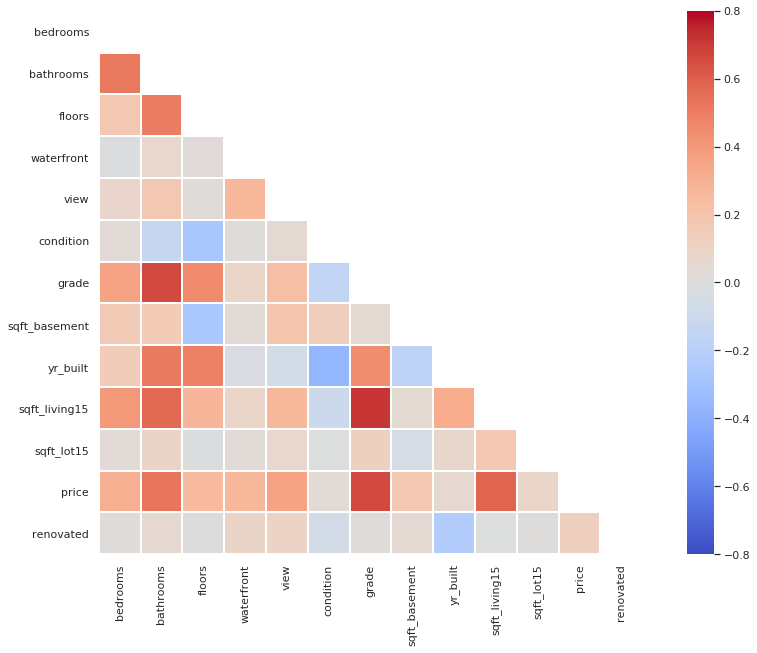

In [261]:
mask = np.zeros_like(testing.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(testing.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8)